In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from IPython.display import display, clear_output
import os.path

In [10]:
products = [
    "G18-ABI-CONUS-BAND07", # GOES-16 East
    "G16-ABI-FD-BAND07", # GOES-18 West
]
km2_per_pixel = 1.0
mi2_per_km2 = 0.386102
time_start = datetime.datetime(2025, 1, 7, 18, 16, 0, 0) # UTC time
time_end = datetime.datetime(2025, 1, 11, 20, 1, 0, 0)
time_step = datetime.timedelta(minutes=5) # GOES update rate
PST_offset = datetime.timedelta(hours=-8)

In [4]:
# pixel and physical coordinates
dx = 0.2
r = 64 # km

x_raw = np.arange(-r, r, 1)
X_raw, Y_raw = np.meshgrid(x_raw, x_raw)

x = np.arange(-r, r, dx)
X, Y = np.meshgrid(x, x)
extent = -r, r, -r, r

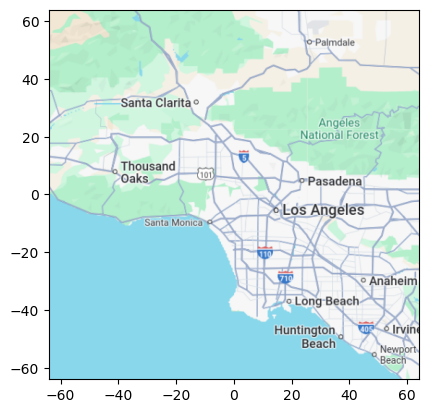

In [5]:
# overlay from Google Maps
reference = plt.imread("reference.png")
plt.imshow(reference, extent=extent)

In [6]:
# templates
shape = (128, 128)
ones = np.ones(shape)
zeros = np.zeros(shape)

In [7]:
fires = {
    "Palisades": {
        "offset": (-17, -8),
        "r": 16,
        "color": "black",
        "area": [],
    },
    "Eaton": {
        "offset": (28, 13),
        "r": 15,
        "color": "purple",
        "area": [],
    },
    "Hurst / Archer": {
        "offset": (-8, 26),
        "r": 7,
        "color": "red",
        "area": [],
    },
    "Lidia": {
        "offset": (15, 40),
        "r": 10,
        "color": "blue",
        "area": [],
    },
    "Sunset": {
        "offset": (3, 2),
        "r": 7,
        "color": "orange",
        "area": [],
    },
    "Kenneth": {
        "offset": (-27, 10),
        "r": 7,
        "color": "maroon",
        "area": [],
    },
}

In [8]:
time = time_start
times = []
data_history = [ zeros ]*12*12 # take the max of 12 hours
while time < time_end:
    fig = plt.figure(figsize=(8,8), dpi=100)

    time_string = time.isoformat().replace("T","+")
    
    images = []
    for product in products:
        path = f"raw/{product}/{time}.png"
        if os.path.isfile(path) and os.path.getsize(path) > 1000:
            img = plt.imread(path)[:,:,0]
            img = np.where(img > 0.9, zeros, img) # fix overflowing issue
        else: #ignore corrupt / empty files
            img = ones
        images.append(img)
        
    new_data = np.clip(1 - 2 * (images[0] * images[1]) ** 0.5, 0, 1) # remap to highlight fires
    
    data_history.pop(0)
    data_history.append(new_data)
    max_data = np.max(np.array(data_history), axis=0)
    
    mix_data = (max_data + new_data)/2

    alpha = max_data ** 0.2 # mask to draw over street map
    alpha = np.where(max_data > 0.1, alpha, zeros)

    # display(fig)
    plt.title(f"{(time + PST_offset).strftime('%d %b %Y, %l:%M %p')} PST")
    plt.imshow(mix_data, extent=extent, cmap="inferno", vmin=0, vmax=1)
    plt.imshow(reference, extent=extent, alpha=0.5)
    plt.imshow(mix_data, extent=extent, alpha=alpha, cmap="inferno", vmin=0, vmax=1)
 
    for key in fires:
        fire = fires[key]

        cx, cy = fire["offset"]
        r = fire["r"]
        # the y coordinate is flipped
        mask = (X_raw - cx)**2 + (Y_raw + cy)**2 < r**2
        
        area = np.sum(max_data[mask] > 0.1) * km2_per_pixel
        fire["area"].append(area)
        if area < 1: continue
            
        patch = plt.Circle(
            (cx, cy), r, color=fire["color"], 
            fill=False, label=f"{key}: {area*mi2_per_km2:.0f} mi$^2$ ({area:.0f} km$^2$)"
        )
        plt.gca().add_patch(patch)
        
    plt.legend(loc='upper left')
    
    plt.xlabel("""kilometers
Satellite analysis can be inaccurate. Refer to fire.ca.gov for official information.
Data: Google Maps, NOAA GOES, UW SSEC  | Code: github.com/xingyzt/fire
""")
    # clear_output(wait=True)
    fig.tight_layout()
    plt.savefig(f"render/{time_string}.png")
    # print(time_string, end=",")
    # plt.pause(.05)
    plt.close()

    time += time_step
    times.append(time)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
day_start = datetime.datetime(2025, 1, 7, 6, 0, 0, 0)
day_end = datetime.datetime(2025, 1, 11, 18, 0, 0, 0)


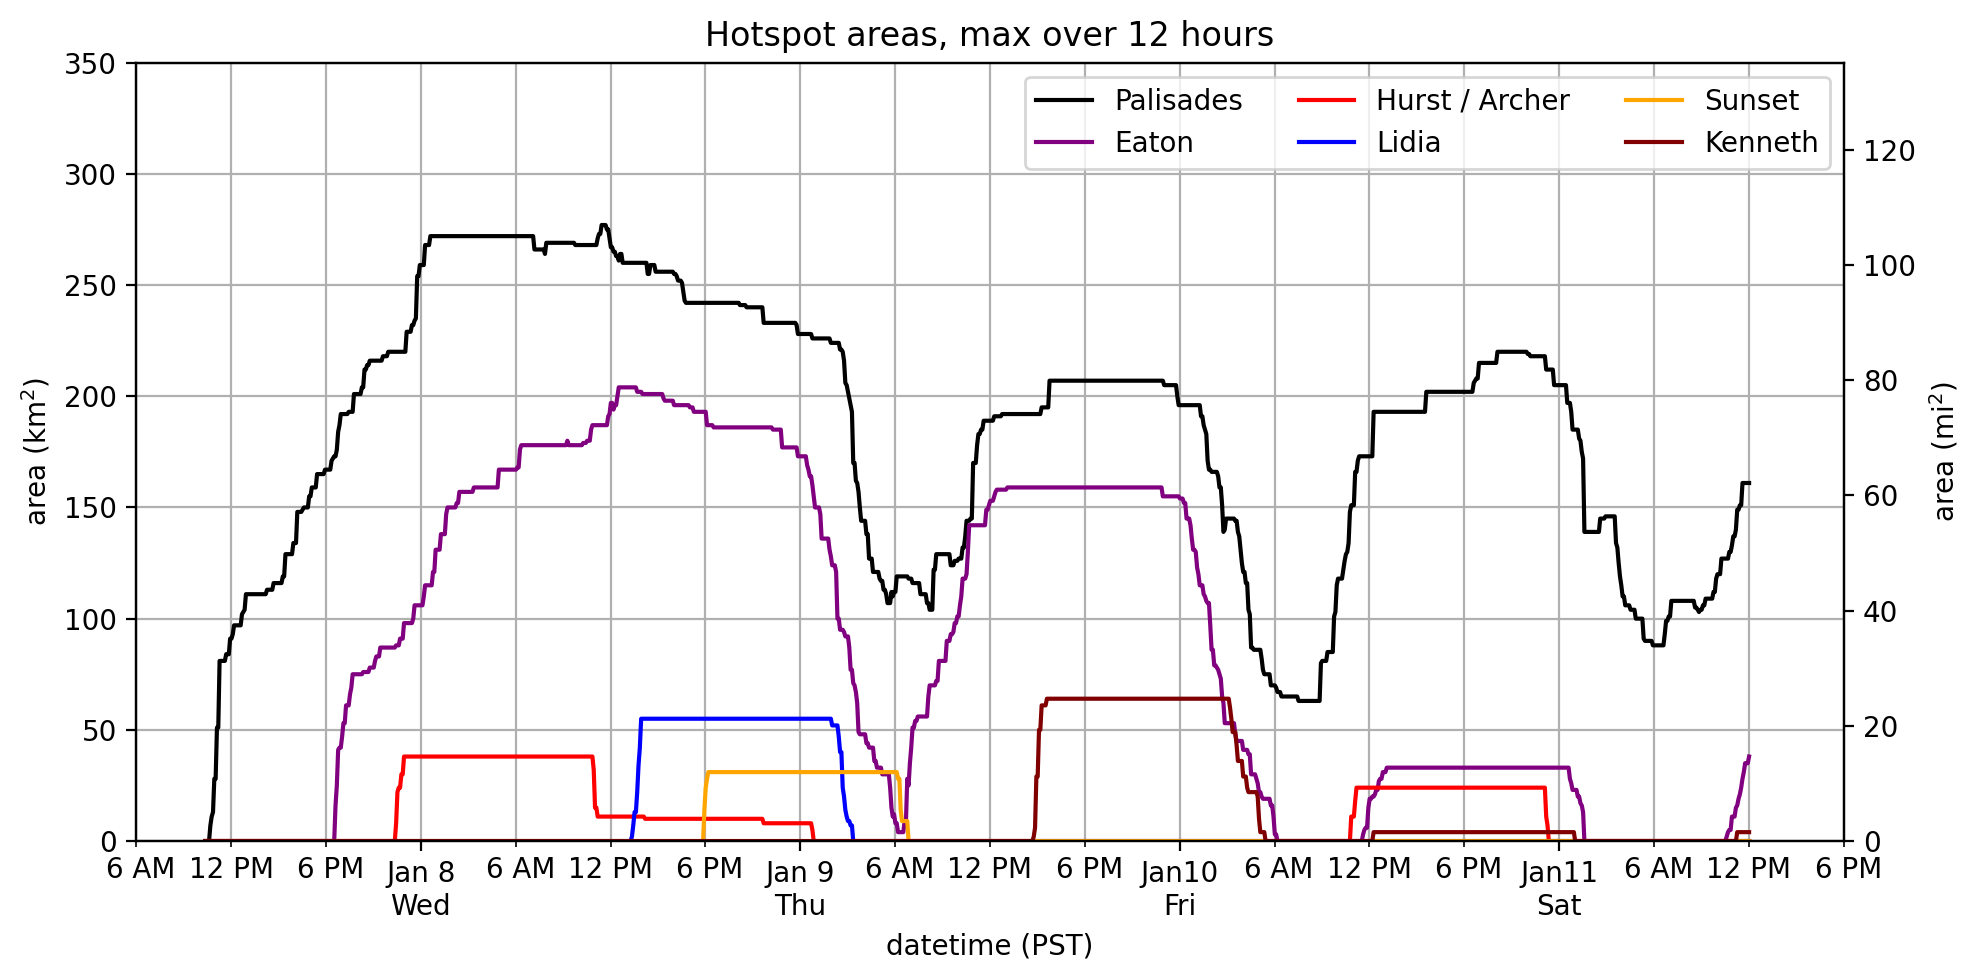

In [12]:
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = plt.subplot()

time_axis = [t + PST_offset for t in times]
for key in fires:
    fire = fires[key]
    plt.plot(time_axis, np.array(fire["area"]), label=key, c=fire["color"])

plt.title("Hotspot areas, max over 12 hours")
plt.legend(ncol=len(fires)//2)

xaxis = ax.xaxis
xaxis.set_major_formatter(mdates.DateFormatter('%b%e\n%a'))
xaxis.set_minor_formatter(mdates.DateFormatter('%l %p'))
xaxis.set_major_locator(mdates.DayLocator(interval=1))
xaxis.set_minor_locator(mdates.HourLocator(interval=6))
day_start = datetime.datetime(2025, 1, 7, 6, 0, 0, 0)
plt.xlim(day_start, day_end)

plt.ylim(0, 350)
plt.ylabel("area (km$^2$)")
plt.xlabel("datetime (PST)")
plt.grid(which='major')
plt.grid(which='minor')

ax2 = ax.twinx()
plt.ylim(0, 350 * mi2_per_km2)
plt.ylabel("area (mi$^2$)")

fig.tight_layout()
plt.savefig("area.png")
plt.show()

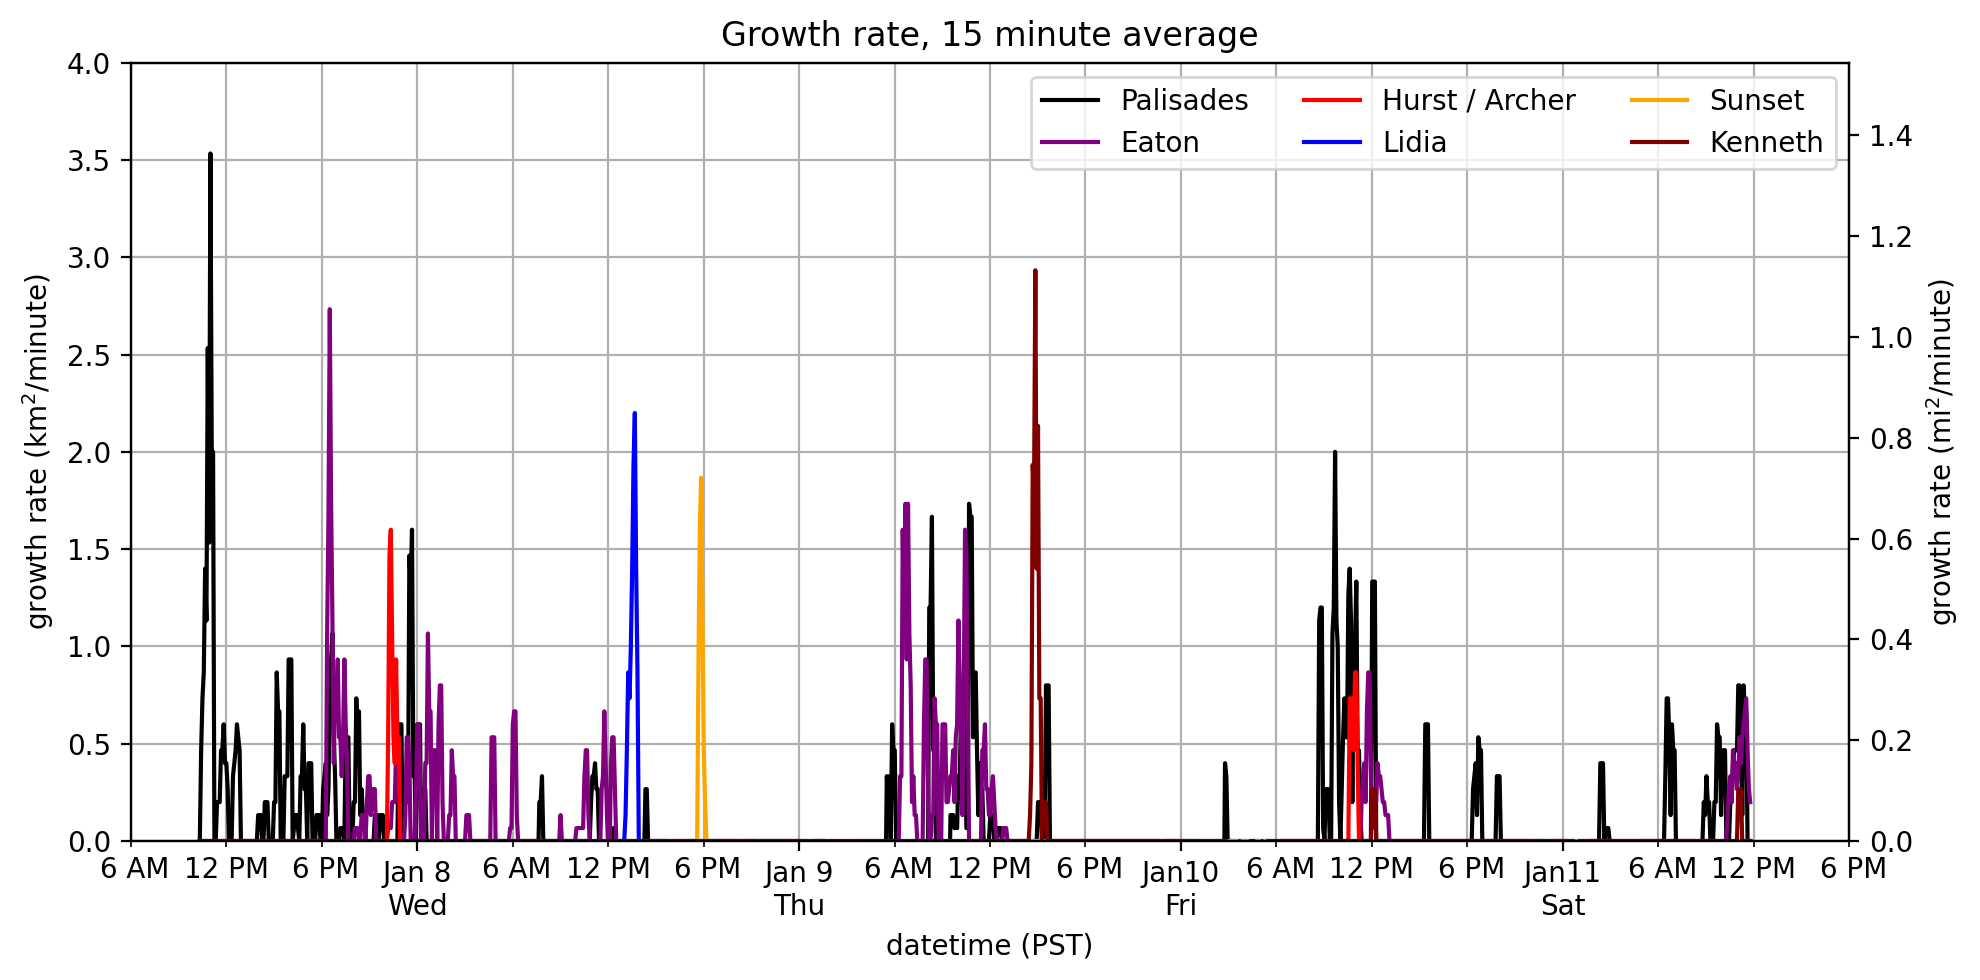

In [13]:
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = plt.subplot()

time_axis = [t + PST_offset for t in times]
for key in fires:
    fire = fires[key]
    da_dt = np.diff(np.array(fire["area"])) / 5 # 5 minute intervals
    window_size = 3
    da_dt_average = np.convolve(da_dt, np.ones(window_size)/window_size, mode='valid')
    
    plt.plot(time_axis[:-window_size], da_dt_average, label=key, c=fire["color"])

plt.title("Growth rate, 15 minute average")
plt.legend(ncol=len(fires)//2)

xaxis = ax.xaxis
xaxis.set_major_formatter(mdates.DateFormatter('%b%e\n%a'))
xaxis.set_minor_formatter(mdates.DateFormatter('%l %p'))
xaxis.set_major_locator(mdates.DayLocator(interval=1))
xaxis.set_minor_locator(mdates.HourLocator(interval=6))
plt.xlim(day_start, day_end)

plt.ylim(0, 4)
plt.ylabel("growth rate (km$^2$/minute)")
plt.xlabel("datetime (PST)")
plt.grid(which='major')
plt.grid(which='minor')

ax2 = ax.twinx()
plt.ylim(0, 4 * mi2_per_km2)
plt.ylabel("growth rate (mi$^2$/minute)")

fig.tight_layout()
plt.savefig("speed.png")
plt.show()